# Module 7: Enhanced Sampling II - Metadynamics (MetaD)

Welcome to Module 7! Following our exploration of Umbrella Sampling in Module 6, we now turn to another powerful enhanced sampling technique: **Metadynamics (MetaD)**.

Unlike Umbrella Sampling, which uses static bias potentials in separate windows, Metadynamics employs a **history-dependent bias potential** that adaptively discourages the system from revisiting previously explored regions of the collective variable (CV) space. This allows the system to overcome energy barriers and explore the free energy landscape more efficiently. We will implement Metadynamics for our 1D double-well potential and reconstruct the PMF from the accumulated bias.

### Setup: Imports and Functions (from Modules 4 & 5)

Let's import libraries and redefine the necessary functions (potential, force, Langevin integrator structure).

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import warnings # To handle potential log(0) issues
import time # To track simulation time

# Plotting style configuration (optional)
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (6,4) # Default figure size
plt.rcParams['lines.linewidth'] = 2

# Assume Boltzmann constant k_B = 1 for simplicity in reduced units
k_B = 1.0
# Define temperature here as it's needed globally
temperature = 1.0 # Will be set properly later

# --- Potential/Force Functions ---
def potential_dw(x, a, b):
  """Calculates the potential energy of a double-well potential."""
  return a * x**4 - b * x**2

def force_dw(x, a, b):
  """Calculates the force from a double-well potential."""
  return -4 * a * x**3 + 2 * b * x

# --- Parameters for Double Well ---
a_dw = 1.0
b_dw = 4.0
minima_pos = np.sqrt(b_dw / (2 * a_dw))
minima_val = potential_dw(minima_pos, a=a_dw, b=b_dw)
barrier_top_val = potential_dw(0, a=a_dw, b=b_dw)
barrier_height = barrier_top_val - minima_val

print("Setup complete. Functions and parameters loaded.")
print(f"Double-well barrier height: {barrier_height:.2f}")

# Beginner-friendly runtime switch
FAST_MODE = True
print(f"FAST_MODE = {FAST_MODE} (set to False for a longer, more converged MetaD run)")


Setup complete. Functions and parameters loaded.
Double-well barrier height: 4.00


## Lesson 7.1: The Concept of Filling the Free Energy Landscape

Metadynamics works by gradually "filling up" the free energy wells along the chosen collective variable(s) $q$ (here, $q=x$). Imagine pouring sand into the potential wells – eventually, the sand fills the wells, making it easier for the particle to escape and explore other regions, including crossing barriers.

Computationally, this is achieved by adding small repulsive potentials (typically Gaussian functions, or "hills") centered at the system's current position in the CV space at regular time intervals. As the simulation progresses:
1.  The system explores a region (e.g., a potential well).
2.  Gaussian hills are deposited in this region, raising its effective energy.
3.  The system is discouraged from revisiting this region and is pushed to explore new areas.
4.  Eventually, enough hills are added to overcome major energy barriers.

The sum of all deposited Gaussian hills forms the history-dependent bias potential, $V_{bias}(x, t)$.

## Lesson 7.2: The Metadynamics Bias

The bias potential in Metadynamics at time $t$ is the sum of all Gaussian hills deposited up to that time:
$$ V_{bias}(x, t) = \sum_{t' \in \{ 	au, 2	au, 3	au, ... \}, t' < t} W \exp\left(-\frac{(x - x(t'))^2}{2\sigma^2}\right) $$
where:
* $x(t')$ is the position (our CV) of the particle at the time $t'$ when a hill was deposited.
* $W$ is the **height** of the Gaussian hills (energy units).
* $\sigma$ (sigma) is the **width** of the Gaussian hills (units of the CV, i.e., length).
* $	au$ (tau) is the **deposition stride** – the time interval (or number of simulation steps) between adding new hills.

**Key Parameters:**
The choice of $W$, $\sigma$, and $	au$ is crucial for the efficiency and accuracy of Metadynamics:
* **Hill Height ($W$):** Should be small compared to the barrier height and $k_B T$. Too large $W$ leads to jerky motion and poor convergence. Too small $W$ leads to slow exploration.
* **Hill Width ($\sigma$):** Should be related to the fluctuations or roughness of the underlying free energy landscape along the CV. Often chosen to be a fraction of the width of the features (like wells) you want to resolve. Too large $\sigma$ smooths out details; too small $\sigma$ can create artificial minima.
* **Deposition Stride ($	au$):** Determines how frequently hills are added. Should be long enough for the system to diffuse slightly away from the last deposited hill, but short enough for efficient exploration.

Finding optimal parameters often requires some trial and error.

The corresponding bias force at time $t$ is the negative gradient of the *total* bias potential:
$$ F_{bias}(x, t) = -\frac{\partial V_{bias}(x, t)}{\partial x} = \sum_{t' < t} W \frac{(x - x(t'))}{\sigma^2} \exp\left(-\frac{(x - x(t'))^2}{2\sigma^2}\right) $$

## Lesson 7.3: Implementing Metadynamics

### Defining Metadynamics Bias Functions

We need functions to calculate the total bias potential and force from a list of deposited hills.

In [2]:
def gaussian(x, center, height, sigma):
  """Calculates the value of a Gaussian function."""
  return height * np.exp(-(x - center)**2 / (2 * sigma**2))

def gaussian_force(x, center, height, sigma):
  """Calculates the force (-dV/dx) from a Gaussian potential."""
  # d/dx [ H * exp(-(x-c)^2 / (2*s^2)) ] = H * exp(...) * [ -(2*(x-c)) / (2*s^2) ]
  # Force = -d/dx = H * exp(...) * (x-c) / s^2
  return gaussian(x, center, height, sigma) * (x - center) / sigma**2

def calculate_metad_bias_potential(x, hills):
  """Calculates the total Metadynamics bias potential at position x from a list of hills."""
  total_bias = 0.0
  # hills is expected to be a list of tuples: [(center1, height1, sigma1), (center2, height2, sigma2), ...]
  for center, height, sigma in hills:
      total_bias += gaussian(x, center, height, sigma)
  return total_bias

def calculate_metad_bias_force(x, hills):
  """Calculates the total Metadynamics bias force at position x from a list of hills."""
  total_force = 0.0
  for center, height, sigma in hills:
      total_force += gaussian_force(x, center, height, sigma)
  return total_force

print("Metadynamics bias functions defined.")

Metadynamics bias functions defined.


### Modifying the Integrator for Metadynamics Bias

We adapt the Langevin integrator to accept the *current list* of deposited hills and use the `calculate_metad_bias_force` function.

In [3]:
def langevin_metad_step(x_curr, v_curr, mass, dt, gamma, target_temp,
                              force_physical_func, current_hills,
                              physical_args={}):
    """
    Performs one step of Langevin dynamics using BAOAB with physical + MetaD bias forces.

    Args:
        x_curr, v_curr, mass, dt, gamma, target_temp: Standard Langevin parameters.
        force_physical_func (callable): Function for the physical force (e.g., force_dw).
        current_hills (list): List of tuples [(center, height, sigma), ...] for deposited hills.
        physical_args (dict): Keyword arguments for the physical force function.

    Returns:
        tuple: (x_new, v_new) - Updated position and velocity.
    """

    # Calculate total force F = F_physical + F_metad_bias
    f_phys_curr = force_physical_func(x_curr, **physical_args)
    f_bias_curr = calculate_metad_bias_force(x_curr, current_hills) # History-dependent bias
    f_total_curr = f_phys_curr + f_bias_curr

    # Update velocity by half step
    v_half_b = v_curr + (f_total_curr / mass) * (dt / 2.0)
    # Update position by half step
    x_half_a = x_curr + v_half_b * (dt / 2.0)
    # Apply friction and random kick (unchanged)
    c1 = np.exp(-gamma * dt)
    c2 = np.sqrt(k_B * max(0, target_temp) * (1.0 - c1**2) / mass)
    random_kick = np.random.normal(0, 1)
    v_half_o = c1 * v_half_b + c2 * random_kick
    # Update position by second half step
    x_new = x_half_a + v_half_o * (dt / 2.0)

    # Calculate total force at *new* position (using the *same* hill list for this step)
    f_phys_new = force_physical_func(x_new, **physical_args)
    f_bias_new = calculate_metad_bias_force(x_new, current_hills) # History-dependent bias
    f_total_new = f_phys_new + f_bias_new

    # Update velocity by second half step
    v_new = v_half_o + (f_total_new / mass) * (dt / 2.0)

    return x_new, v_new

print("Langevin integrator adapted for Metadynamics.")

Langevin integrator adapted for Metadynamics.


### Setting Metadynamics Parameters

Define the hill height `W`, width `sigma`, deposition stride `tau`, and simulation length.

#### 7.2.1 Estimating Hill Width (σ) from Unbiased Sampling

First, run a short unbiased MD (no metadynamics bias) to sample natural fluctuations of the CV. Then compute its standard deviation as the hill width.


Estimated hill width σ = 0.138


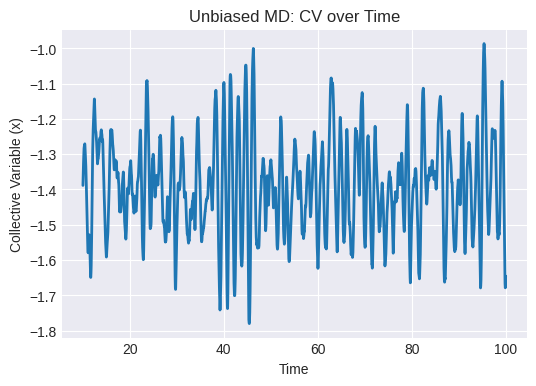

In [13]:
# Unbiased MD to estimate sigma
num_steps_unbiased = 3000 if FAST_MODE else 10000

# Simulation parameters
mass = 1.0
dt = 0.01
gamma = 1.0
target_temp_metad = barrier_height * 0.1 # 10% of the barrier height
temperature = target_temp_metad # Update global temperature

x = 0.0  # start at center
v = 0.0
positions_unbiased = []
times_unbiased = []  # Store time points for plotting

for step in range(num_steps_unbiased):
    # Simple Langevin without bias, reuse langevin_metad_step with zero bias
    x, v = langevin_metad_step(x, v, mass=1.0, dt=dt, gamma=gamma,
                               target_temp=temperature,
                               force_physical_func=force_dw, current_hills=[],
                               physical_args={'a': a_dw, 'b': b_dw})
    positions_unbiased.append(x)
    times_unbiased.append(step * dt)  # Record time

# Discard initial 10% for equilibration
positions_unbiased = np.array(positions_unbiased[int(num_steps_unbiased/10):])
times_unbiased = np.array(times_unbiased[int(num_steps_unbiased/10):])

# Calculate and print standard deviation (sigma)
sigma_est = np.std(positions_unbiased)
print(f"Estimated hill width σ = {sigma_est:.3f}")

# Plot CV over time
plt.figure(figsize=(6, 4))
plt.plot(times_unbiased, positions_unbiased)
plt.xlabel("Time")
plt.ylabel("Collective Variable (x)")
plt.title("Unbiased MD: CV over Time")
plt.grid(True)
plt.show()

In [15]:
# Metadynamics Parameters (using estimated σ and barrier/20)
# Hill width and height based on prior estimates
metad_hill_sigma = sigma_est  # from unbiased sampling
metad_hill_height = barrier_height / 50  # ~1/50 of barrier
metad_deposition_stride = 50 if FAST_MODE else 100  # tau - steps between depositions

# Simulation parameters
mass = 1.0
dt = 0.01
gamma = 1.0
target_temp_metad = temperature  # already set
n_steps_metad = 30000 if FAST_MODE else 200000
record_stride_metad = 50 if FAST_MODE else 100

print("Metadynamics Parameters:")
print(f"  Hill width (σ): {metad_hill_sigma:.3f}")
print(f"  Hill height (W): {metad_hill_height:.3f}")
print(f"  Deposition stride: {metad_deposition_stride}")
print(f"  Total steps: {n_steps_metad}")


Metadynamics Parameters:
  Hill width (σ): 0.138
  Hill height (W): 0.080
  Deposition stride: 100
  Total steps: 200000


### 7.2.2 Setting Hill Width and Height

- **Hill width (σ)** is set to the standard deviation estimated above: `σ = sigma_est`.
- **Hill height (W)** is set to `barrier_height / 50`, i.e., 1/50 of the estimated barrier height.


### Coding Exercise: Running the Metadynamics Simulation

Implement the Metadynamics simulation loop:
1.  Initialize position, velocity, and an empty list `hills` to store Gaussian parameters.
2.  Loop for `n_steps_metad`:
    * Call the `langevin_baoab_metad_step` integrator, passing the *current* `hills` list.
    * Every `metad_deposition_stride` steps:
        * Add the parameters (`x_curr`, `metad_hill_height`, `metad_hill_sigma`) of a new Gaussian hill centered at the *current* position to the `hills` list.
    * Record position and current time periodically.
    * Optionally, record the height of the bias potential at the current position to monitor filling.

In [16]:
# --- Run Metadynamics Simulation ---

# Data storage
n_recorded_metad = n_steps_metad // record_stride_metad + 1
times_metad = np.zeros(n_recorded_metad)
positions_metad = np.zeros(n_recorded_metad)
bias_potential_at_x = np.zeros(n_recorded_metad) # Track bias value at particle's position
hills = [] # List to store deposited hills: [(center, height, sigma), ...]
num_hills_deposited = [] # Track number of hills over time

# Initial conditions
x_curr = -minima_pos # Start in the left well
v_curr = 0.0

# Store initial state
record_idx = 0
positions_metad[record_idx] = x_curr
bias_potential_at_x[record_idx] = 0.0
times_metad[record_idx] = 0.0
num_hills_deposited.append(0)

print(f"Starting Metadynamics simulation ({n_steps_metad} steps)...")
start_time = time.time()

# Main simulation loop
for i in range(n_steps_metad):
    # Deposit hill if stride is reached
    if (i + 1) % metad_deposition_stride == 0:
        hills.append((x_curr, metad_hill_height, metad_hill_sigma))
        if (len(hills) % 100 == 0): # Print progress periodically
             print(f"  Step {i+1}, Deposited {len(hills)} hills...")

    # Perform one integration step using current hills list
    x_curr, v_curr = langevin_metad_step(
        x_curr, v_curr, mass, dt, gamma, target_temp_metad,
        force_dw, hills,
        physical_args={'a': a_dw, 'b': b_dw}
    )

    # Record data
    if (i + 1) % record_stride_metad == 0:
        record_idx += 1
        if record_idx < n_recorded_metad:
            times_metad[record_idx] = (i + 1) * dt
            positions_metad[record_idx] = x_curr
            # Calculate current bias potential value at particle position (can be slow if many hills)
            bias_potential_at_x[record_idx] = calculate_metad_bias_potential(x_curr, hills)
            num_hills_deposited.append(len(hills))


end_time = time.time()
print(f"Metadynamics simulation finished. Time taken: {end_time - start_time:.2f} seconds.")
print(f"Total hills deposited: {len(hills)}")

# Trim recorded arrays if simulation ended before last recording step
times_metad = times_metad[:record_idx+1]
positions_metad = positions_metad[:record_idx+1]
bias_potential_at_x = bias_potential_at_x[:record_idx+1]
# Ensure num_hills_deposited aligns with times_metad
num_hills_deposited_timed = np.interp(times_metad, np.arange(len(num_hills_deposited)) * metad_deposition_stride * dt, num_hills_deposited).astype(int)

Starting Metadynamics simulation (200000 steps)...
  Step 10000, Deposited 100 hills...
  Step 20000, Deposited 200 hills...
  Step 30000, Deposited 300 hills...
  Step 40000, Deposited 400 hills...
  Step 50000, Deposited 500 hills...
  Step 60000, Deposited 600 hills...
  Step 70000, Deposited 700 hills...
  Step 80000, Deposited 800 hills...
  Step 90000, Deposited 900 hills...
  Step 100000, Deposited 1000 hills...
  Step 110000, Deposited 1100 hills...
  Step 120000, Deposited 1200 hills...
  Step 130000, Deposited 1300 hills...
  Step 140000, Deposited 1400 hills...
  Step 150000, Deposited 1500 hills...
  Step 160000, Deposited 1600 hills...
  Step 170000, Deposited 1700 hills...
  Step 180000, Deposited 1800 hills...
  Step 190000, Deposited 1900 hills...
  Step 200000, Deposited 2000 hills...
Metadynamics simulation finished. Time taken: 901.39 seconds.
Total hills deposited: 2000


## Lesson 7.4: Reconstructing the Free Energy

In Metadynamics, the simulation explores the landscape by progressively filling the wells with the bias potential $V_{bias}(x, t)$. As the simulation converges (i.e., the particle diffuses back and forth across the landscape relatively freely), the accumulated bias potential becomes an estimate of the negative of the underlying free energy (PMF), up to an irrelevant additive constant:

$$ F(x) \approx -V_{bias}(x, t \to \infty) + C $$

Therefore, we can reconstruct the PMF simply by calculating the negative of the total bias potential from *all* the deposited hills at the end of the simulation.

**Monitoring Convergence:**
How do we know if the simulation has run long enough ("converged")?
* **Trajectory:** Plot the position $x$ vs. time. Has the particle crossed the main barrier(s) multiple times?
* **Bias Potential Growth:** Plot the height of the bias potential evaluated at the particle's current position ($V_{bias}(x(t), t)$) vs. time. It should initially increase as wells are filled, then plateau or fluctuate around a relatively constant value once the main barriers are overcome.
* **Collective Variable Diffusion:** The particle should appear to diffuse relatively freely along the CV once the landscape is filled.
* **PMF Stability:** Calculate the PMF estimate ($-V_{bias}$) using hills deposited up to different times (e.g., half the simulation vs. the full simulation). If the PMF shape is stable, it suggests convergence.

Let's visualize the trajectory and the bias potential growth first.

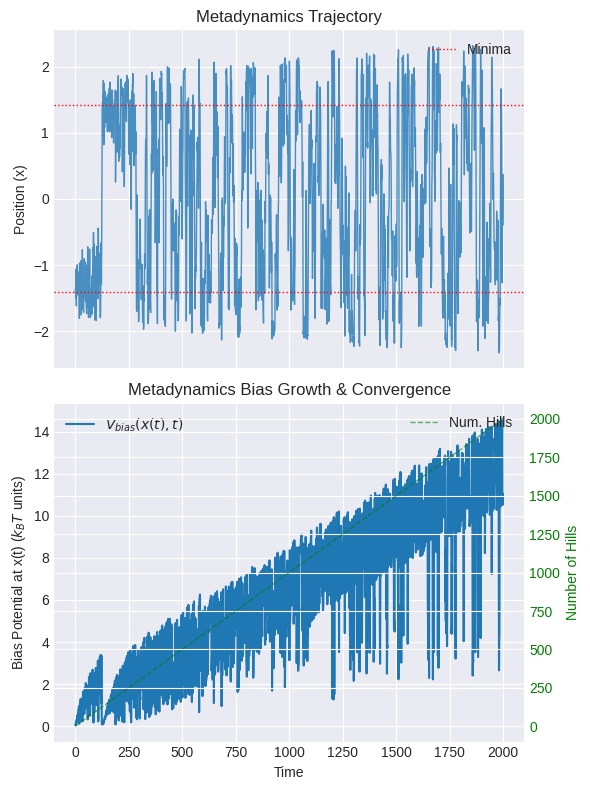

Check if the trajectory explores both wells and crosses the barrier.
Check if the bias potential growth starts to level off (indicating wells are being filled).


In [17]:
# --- Visualize Metadynamics Trajectory and Convergence ---

fig, axes = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

# Plot position vs time
axes[0].plot(times_metad, positions_metad, lw=1, alpha=0.8)
axes[0].set_ylabel("Position (x)")
axes[0].set_title("Metadynamics Trajectory")
axes[0].grid(True)
axes[0].axhline(-minima_pos, color='r', linestyle=':', linewidth=1, label='Minima')
axes[0].axhline(minima_pos, color='r', linestyle=':', linewidth=1)
axes[0].legend(loc='upper right')


# Plot bias potential at current position vs time
axes[1].plot(times_metad, bias_potential_at_x, lw=1.5, label='$V_{bias}(x(t), t)$')
# Add number of hills on secondary y-axis
ax1b = axes[1].twinx()
ax1b.plot(times_metad, num_hills_deposited_timed, 'g--', lw=1, alpha=0.6, label='Num. Hills')
ax1b.set_ylabel("Number of Hills", color='g')
ax1b.tick_params(axis='y', labelcolor='g')

axes[1].set_xlabel("Time")
axes[1].set_ylabel("Bias Potential at x(t) ($k_B T$ units)")
axes[1].set_title("Metadynamics Bias Growth & Convergence")
axes[1].grid(True)
axes[1].legend(loc='upper left')
ax1b.legend(loc='upper right')


plt.tight_layout()
plt.show()

print("Check if the trajectory explores both wells and crosses the barrier.")
print("Check if the bias potential growth starts to level off (indicating wells are being filled).")

### Exercise: Calculating and Plotting the Reconstructed PMF

Now, calculate the final total bias potential $V_{bias}(x, t_{final})$ over a grid of $x$ values using all the deposited `hills`. The reconstructed PMF is then $-V_{bias}(x, t_{final})$. Plot this against the analytical potential.

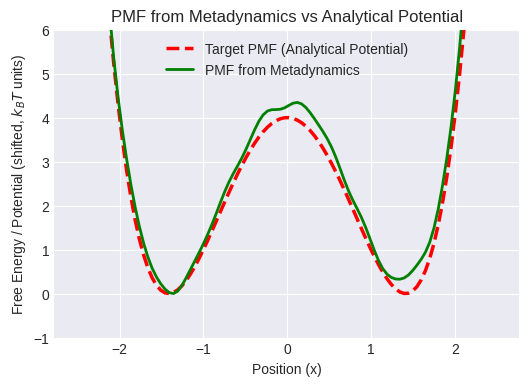

PMF Barrier Height (Metadynamics, approx): 14.48
Compare the green line (PMF from MetaD) to the red dashed line (analytical).
Accuracy depends on simulation length and MetaD parameters.


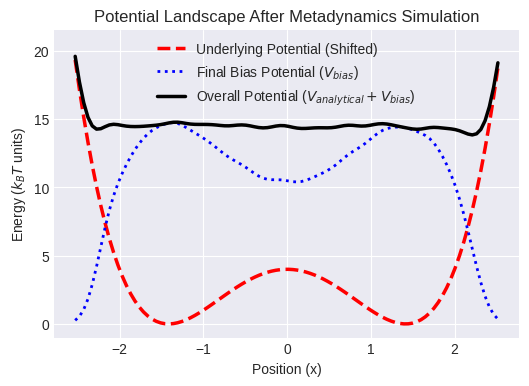


The black line shows the 'flattened' landscape the particle sees at the end.
The bias potential (blue dotted) effectively cancels the underlying potential wells (red dashed).


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import warnings # To handle potential log(0) issues
import time # To track simulation time

# --- Calculate and Plot Reconstructed PMF ---

# Define grid for calculating final PMF
n_bins_pmf = 100
# Ensure positions_metad is not empty before calculating min/max
if len(positions_metad) > 0:
    pmf_grid = np.linspace(min(positions_metad)-0.2, max(positions_metad)+0.2, n_bins_pmf) # Grid based on sampled range
else:
    # Provide a default grid if positions_metad is empty
    pmf_grid = np.linspace(-2, 2, n_bins_pmf)
    print("Warning: positions_metad is empty. Using default grid for PMF.")


# Calculate final bias potential on the grid using *all* deposited hills
# Ensure hills list is not empty
if len(hills) > 0:
    final_bias_potential = np.array([calculate_metad_bias_potential(x, hills) for x in pmf_grid])
else:
    final_bias_potential = np.zeros_like(pmf_grid) # Bias is zero if no hills deposited
    print("Warning: hills list is empty. Final bias potential is zero.")


# Reconstructed PMF = - Final Bias Potential
pmf_metad = -final_bias_potential

# Shift PMF so minimum is zero (only if pmf_metad is not all zeros)
if np.any(pmf_metad):
    min_pmf_metad = np.min(pmf_metad)
    pmf_metad -= min_pmf_metad
else:
    min_pmf_metad = 0 # Keep minimum at zero if PMF is flat

# Calculate analytical potential on the same grid for comparison
analytical_potential_metad = potential_dw(pmf_grid, a=a_dw, b=b_dw)
analytical_potential_metad -= minima_val # Shift minimum to zero


# --- Plot Reconstructed PMF vs Analytical ---
# plt.figure(figsize=(10, 7))

# Plot analytical potential
plt.plot(pmf_grid, analytical_potential_metad, 'r--', linewidth=2.5, label="Target PMF (Analytical Potential)")

# Plot Metadynamics PMF
plt.plot(pmf_grid, pmf_metad, 'g-', linewidth=2, label="PMF from Metadynamics")

plt.xlabel("Position (x)")
plt.ylabel("Free Energy / Potential (shifted, $k_B T$ units)")
plt.title("PMF from Metadynamics vs Analytical Potential")
# Use calculated barrier_height if available, otherwise use a default
try:
    plot_ylim_upper = barrier_height * 1.5 if barrier_height > 0 else 5
except NameError:
    plot_ylim_upper = max(np.max(analytical_potential_metad) * 1.1, 5) # Default based on analytical potential
plt.ylim(-1, plot_ylim_upper) # Adjust ylim
plt.legend()
plt.grid(True)
plt.show()

# Calculate and print barrier height only if pmf_metad is not flat zero
if np.any(pmf_metad):
    print(f"PMF Barrier Height (Metadynamics, approx): {np.max(pmf_metad):.2f}")
else:
    print("PMF from Metadynamics is flat (likely no hills deposited or converged bias is zero).")
print("Compare the green line (PMF from MetaD) to the red dashed line (analytical).")
print("Accuracy depends on simulation length and MetaD parameters.")


# --- Visualize Overall Potential Landscape ---
# This part uses variables calculated above in this same cell.

# Calculate the overall potential (shifted analytical + final bias)
overall_potential = analytical_potential_metad + final_bias_potential

# Plot the shifted analytical potential (underlying FE)
plt.plot(pmf_grid, analytical_potential_metad, 'r--', linewidth=2.5, label="Underlying Potential (Shifted)")

# Plot the final accumulated bias potential
plt.plot(pmf_grid, final_bias_potential, 'b:', linewidth=2, label="Final Bias Potential ($V_{bias}$)")

# Plot the overall potential felt by the particle at the end
plt.plot(pmf_grid, overall_potential, 'k-', linewidth=2.5, label="Overall Potential ($V_{analytical} + V_{bias}$)")


plt.xlabel("Position (x)")
plt.ylabel("Energy ($k_B T$ units)")
plt.title("Potential Landscape After Metadynamics Simulation")
# Adjust ylim for better visualization, considering the bias potential height
plot_ylim_lower_overall = min(np.min(analytical_potential_metad), np.min(overall_potential)) - 1
plot_ylim_upper_overall = max(np.max(final_bias_potential)*1.2, np.max(overall_potential)*1.1, 10)
plt.ylim(plot_ylim_lower_overall, plot_ylim_upper_overall)
plt.legend()
plt.grid(True)
plt.show()

print("\nThe black line shows the 'flattened' landscape the particle sees at the end.")
print("The bias potential (blue dotted) effectively cancels the underlying potential wells (red dashed).")


### 7.4.2 Convergence of PMF vs. Number of Hills

After reconstructing the PMF from all deposited hills, assess convergence by rebuilding the PMF using only the first \(m\) hills (for \(m = 50, 100, \dots\)):

- Compute the PMF on the same grid for subsets of hills.  
- Track:
  - ΔG between the two minima  
  - Barrier height between minima  

Plot these as a function of the number of hills to ensure the PMF has stabilized.


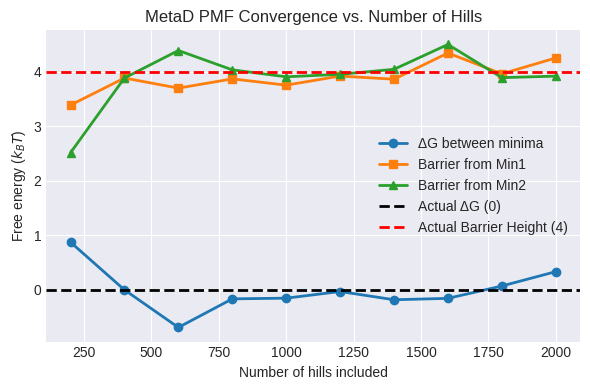

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# --- Reconstruct full PMF from all hills (for reference) ---
# # Define grid based on sampled CV range
# n_bins_pmf = 100

# Compute underlying (analytical) potential on that grid
underlying = potential_dw(pmf_grid, a=a_dw, b=b_dw)

# --- Convergence analysis: PMF vs. Number of Hills in steps of 200 ---

# Known CV positions of the two minima and the barrier
min1_pos, min2_pos, barrier_pos = -1.41, +1.41, 0.00

# Map those to the closest grid indices
idx1 = np.argmin(np.abs(pmf_grid - min1_pos))
idx2 = np.argmin(np.abs(pmf_grid - min2_pos))
idxb = np.argmin(np.abs(pmf_grid - barrier_pos))

# Prepare hill‐count steps
nsteps = 200
total_hills = len(hills)
steps = np.arange(nsteps, total_hills + 1, nsteps)

# Storage for free‐energy metrics
dg_minima   = []
barrier_h1  = []
barrier_h2  = []

# Loop over subsets of the first m hills
for m in steps:
    # Build bias from hills 0 … m-1
    bias_m = np.array([calculate_metad_bias_potential(x, hills[:m])
                       for x in pmf_grid])
    # Reconstruct subset‐PMF and shift min to zero
    pmf_m = - bias_m
    pmf_m -= np.min(pmf_m)

    # ΔG between minima
    dg_minima.append(pmf_m[idx2] - pmf_m[idx1])
    # Barrier heights measured from each minimum
    barrier_h1.append(pmf_m[idxb] - pmf_m[idx1])
    barrier_h2.append(pmf_m[idxb] - pmf_m[idx2])

# Plot the convergence curves
plt.figure(figsize=(6, 4))
plt.plot(steps, dg_minima,  marker='o', label='ΔG between minima')
plt.plot(steps, barrier_h1, marker='s', label='Barrier from Min1')
plt.plot(steps, barrier_h2, marker='^', label='Barrier from Min2')

# Add lines for actual delta G and barrier height
plt.axhline(y=0, color='black', linestyle='--', label='Actual ΔG (0)')  # delta G
plt.axhline(y=4, color='red', linestyle='--', label='Actual Barrier Height (4)')  # barrier height

plt.xlabel('Number of hills included')
plt.ylabel('Free energy ($k_B T$)')
plt.title('MetaD PMF Convergence vs. Number of Hills')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Lesson 7.5: Comparing US and MetaD

**Umbrella Sampling (US)**  
- Windows can be run **in parallel**—each umbrella simulation is independent.  
- Fast & robust convergence for 1D collective variables.  
- For multiple CVs, the grid grows exponentially (e.g., 10×10 = 100 windows for 2D), which becomes computationally expensive.  
- Requires **prior knowledge** of which regions to sample to place umbrellas effectively.

**Metadynamics (MetaD)**  
- Runs **a single long** simulation, adaptively filling unknown regions of the free-energy landscape.  
- No need to predefine all minima/barriers—exploration is driven by the history-dependent bias.  
- Scales better to 2D+ CV spaces—avoids the combinatorial explosion of umbrellas.  
- May require longer wall-clock time to accumulate sufficient bias for convergence.


---
End of Module 7. We have explored and implemented Metadynamics:

* **Metadynamics Concept:** Understood how adding history-dependent Gaussian hills fills free energy wells and facilitates barrier crossing.
* **Implementation:** Modified the Langevin integrator and simulation loop to incorporate the time-dependent MetaD bias.
* **PMF Reconstruction:** Learned that the converged MetaD bias potential provides an estimate of the negative free energy ($F(x) \approx -V_{bias}$).
* **Visualization & Comparison:** Ran a MetaD simulation, monitored its progress, reconstructed the PMF, and compared it to the analytical potential and discussed its pros/cons relative to Umbrella Sampling.